In [1]:
CITY = 3304557
CITY_NAME = 'Rio de Janeiro'
STATE = 'RJ'
FILENAME_DATA = f'../../data/dengue_{CITY}_cluster.csv'
FILE_CHIK = f'../../data/chik_{CITY}_cluster.csv'

In [2]:
import sys
import pickle
sys.path.append('../..')
import numpy as np
import tensorflow as tf
import pandas as pd
from datetime import datetime
from pgbm_model import pgbm_pred
import matplotlib.pyplot as plt
from preprocessing import get_nn_data
from lstm import build_model, make_pred
from plots_lstm import plot_loss, plot_comp 
from sklearn.metrics import mean_squared_error as mse 

In [3]:
df_dengue = pd.read_csv(FILENAME_DATA, index_col = 'Unnamed: 0' )
df_dengue.index = pd.to_datetime(df_dengue.index)
df_dengue

,casos_3304557,casos_est_3304557,casos_est_min_3304557,casos_est_max_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557,...,casos_3303203,casos_est_3303203,casos_est_min_3303203,casos_est_max_3303203,p_rt1_3303203,p_inc100k_3303203,temp_min_3303203,temp_max_3303203,umid_min_3303203,pressao_min_3303203
2010-01-03,31,31.0,31,31.0,0.000000,0.459408,24.919604,30.475486,66.631786,0.993175,...,0,0.0,0,0,0.0,0.000000,24.576307,29.725882,69.104197,0.993357
2010-01-10,45,45.0,45,45.0,0.000000,0.666883,25.529044,32.125244,64.584100,0.995633,...,0,0.0,0,0,0.0,0.000000,25.422472,32.090062,62.984778,0.995616
2010-01-17,48,48.0,48,48.0,0.000000,0.711341,25.359598,31.999538,61.707908,0.997928,...,0,0.0,0,0,0.0,0.000000,25.379813,31.698752,60.738886,0.998017
2010-01-24,56,56.0,56,56.0,0.000000,0.829898,25.297887,32.134447,60.643620,0.996875,...,0,0.0,0,0,0.0,0.000000,25.125737,31.560263,60.907331,0.996876
2010-01-31,69,69.0,69,69.0,0.000000,1.022553,24.752454,31.623125,61.756186,0.997307,...,1,1.0,1,1,0.0,0.614655,24.321585,31.186035,61.491648,0.997287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-19,1301,1365.0,1310,1436.0,1.000000,20.228771,22.422786,29.246966,64.543411,1.001222,...,0,0.0,0,0,0.0,0.000000,22.476702,28.662031,66.835809,1.001193
2023-03-26,1439,1556.0,1452,1731.0,1.000000,23.059317,22.705122,31.532885,55.172254,1.000216,...,0,0.0,0,0,0.0,0.000000,22.541068,30.294761,63.231120,1.000406
2023-04-02,1205,1431.0,1220,1973.0,0.984832,21.206865,23.266584,28.715598,65.543365,0.999732,...,0,0.0,0,0,0.0,0.000000,23.014365,28.333513,66.737119,0.999870
2023-04-09,1265,1773.0,1281,3818.0,1.000000,26.275171,21.788199,26.828910,69.926135,1.000576,...,0,0.0,0,0,0.0,0.000000,21.670680,26.087616,73.382634,1.000633


## Neural network model 

Parameters of the models:

In [4]:
END_TRAIN_DATE = '2018-09-30'
END_DATE = '2019-12-01'


PREDICT_N = 4 # number of new days predicted
LOOK_BACK = 4 # number of last days used to make the prediction 
BATCH_SIZE = 1
EPOCHS = 400
HIDDEN = 8
FEAT = 98 # number of features
l1 = 1e-6
l2 = 1e-6

Let's train the model with the loss function == msle 

Compilation Time :  0.0033249855041503906
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 98)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             6848      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 4)                 36        
                   

2023-05-07 00:28:35.018319: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


95/95 [==============================] - 2s 6ms/step - loss: 0.0113 - accuracy: 0.2947 - mape: 366.8392 - mse: 0.0177 - val_loss: 0.0157 - val_accuracy: 0.2353 - val_mape: 274.7549 - val_mse: 0.0292
Epoch 2/400
95/95 [==============================] - 0s 3ms/step - loss: 0.0057 - accuracy: 0.2947 - mape: 159.6152 - mse: 0.0097 - val_loss: 0.0061 - val_accuracy: 0.2794 - val_mape: 111.6413 - val_mse: 0.0122
Epoch 3/400
95/95 [==============================] - 0s 3ms/step - loss: 0.0036 - accuracy: 0.3079 - mape: 119.9798 - mse: 0.0057 - val_loss: 0.0074 - val_accuracy: 0.3235 - val_mape: 92.7007 - val_mse: 0.0152
Epoch 4/400
95/95 [==============================] - 0s 3ms/step - loss: 0.0034 - accuracy: 0.2763 - mape: 118.0898 - mse: 0.0055 - val_loss: 0.0048 - val_accuracy: 0.2941 - val_mape: 97.5036 - val_mse: 0.0093
Epoch 5/400
95/95 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 0.3158 - mape: 119.7734 - mse: 0.0044 - val_loss: 0.0039 - val_accuracy: 0.352

Epoch 40/400
95/95 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.4289 - mape: 113.3735 - mse: 0.0018 - val_loss: 0.0014 - val_accuracy: 0.5000 - val_mape: 89.8332 - val_mse: 0.0020
Epoch 41/400
95/95 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.3921 - mape: 103.2523 - mse: 0.0015 - val_loss: 0.0032 - val_accuracy: 0.3235 - val_mape: 93.0830 - val_mse: 0.0064
Epoch 42/400
95/95 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 0.4658 - mape: 103.3163 - mse: 0.0015 - val_loss: 0.0020 - val_accuracy: 0.4412 - val_mape: 102.8612 - val_mse: 0.0037
Epoch 43/400
95/95 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.4553 - mape: 97.7531 - mse: 0.0019 - val_loss: 0.0019 - val_accuracy: 0.3824 - val_mape: 101.7947 - val_mse: 0.0033
Epoch 44/400
95/95 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 0.4421 - mape: 117.3306 - mse: 0.0026 - val_loss: 0.0023 - val

Epoch 79/400
95/95 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.4368 - mape: 102.7267 - mse: 0.0019 - val_loss: 0.0021 - val_accuracy: 0.4265 - val_mape: 123.7377 - val_mse: 0.0039
Epoch 80/400
95/95 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.4553 - mape: 117.4367 - mse: 0.0019 - val_loss: 0.0014 - val_accuracy: 0.5000 - val_mape: 98.7400 - val_mse: 0.0021
Epoch 81/400
95/95 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 0.4737 - mape: 110.0134 - mse: 0.0012 - val_loss: 0.0020 - val_accuracy: 0.3824 - val_mape: 84.8944 - val_mse: 0.0036
Epoch 82/400
95/95 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 0.4421 - mape: 104.0005 - mse: 0.0017 - val_loss: 0.0018 - val_accuracy: 0.4118 - val_mape: 110.2003 - val_mse: 0.0033
Epoch 83/400
95/95 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 0.4658 - mape: 95.7683 - mse: 0.0022 - val_loss: 0.0023 - val

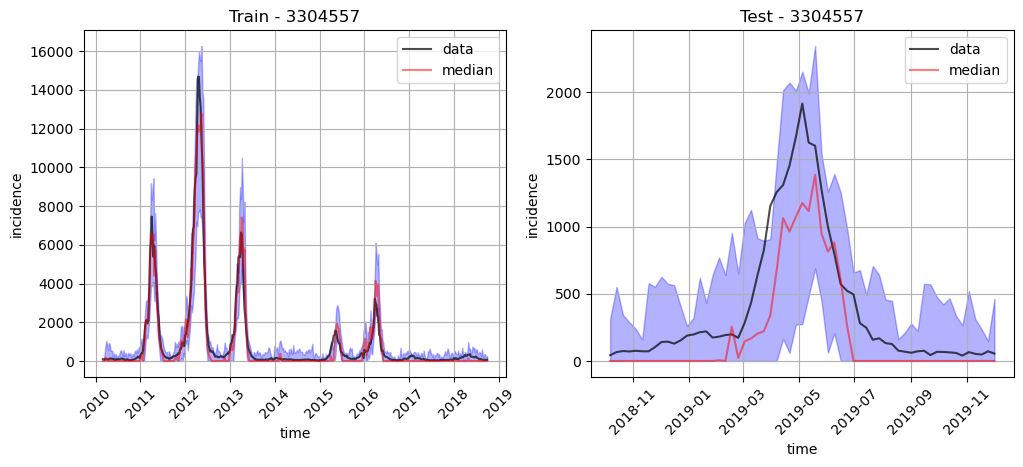

In [5]:
model = build_model(l1=l1, l2 = l2, hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=BATCH_SIZE, loss = 'msle', lr = 0.001)

m_msle_all, h_msle_all, m_train_all, m_val_all = make_pred(model, CITY, doenca = 'dengue', epochs = EPOCHS, end_train_date = END_TRAIN_DATE, 
                    ratio= None, end_date = END_DATE,
                     predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'msle_all',  filename = FILENAME_DATA)

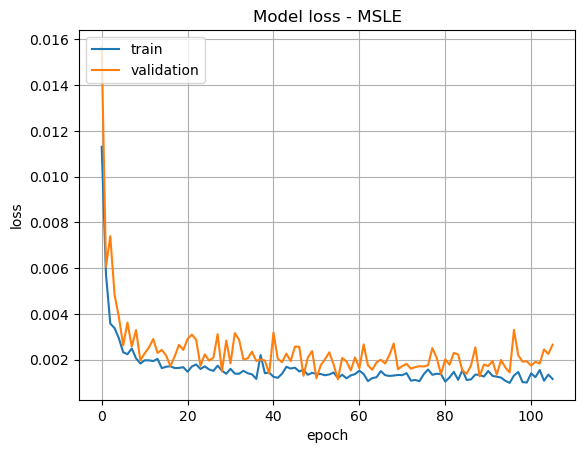

In [6]:
plot_loss(h_msle_all, title = 'Model loss - MSLE')

PGBM model

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Estimator 0/100, Train metric: 1950.9005
Estimator 1/100, Train metric: 1781.6929
Estimator 2/100, Train metric: 1626.3829
Estimator 3/100, Train metric: 1487.5207
Estimator 4/100, Train metric: 1361.4814
Estimator 5/100, Train metric: 1246.8706
Estimator 6/100, Train metric: 1139.6541
Estimator 7/100, Train metric: 1044.5004
Estimator 8/100, Train metric: 957.6065
Estimator 9/100, Train metric: 876.0708
Estimator 10/100, Train metric: 803.9766
Estimator 11/100, Train metric: 737.5285
Estimator 12/100, Train metric: 676.6351
Estimator 13/100, Train metric: 620.7319
Estimator 14/100, Train metric: 570.2780
Estimator 15/100, Train metric: 524.2835
Estimator 16/100, Train metric: 481.9279
Estimator 17/100, Train metric: 443.1919
Estimator 18/100, Train metric: 407.8085
Estimator 19/100, Train metric: 375.5492
Estimator 20/100, Train metric: 346.1109
Estimator 21/100, Train metric: 319.1096
Estimator 22/100, Train metric: 294.5344
Estimator 23/100, Train metric: 272.1268
Estimator 24/100, 

Estimator 4/100, Train metric: 1366.3337
Estimator 5/100, Train metric: 1251.3198
Estimator 6/100, Train metric: 1147.1414
Estimator 7/100, Train metric: 1052.0164
Estimator 8/100, Train metric: 966.0776
Estimator 9/100, Train metric: 887.9489
Estimator 10/100, Train metric: 816.9464
Estimator 11/100, Train metric: 750.9414
Estimator 12/100, Train metric: 690.9821
Estimator 13/100, Train metric: 636.2547
Estimator 14/100, Train metric: 584.5477
Estimator 15/100, Train metric: 538.9533
Estimator 16/100, Train metric: 496.2814
Estimator 17/100, Train metric: 458.1003
Estimator 18/100, Train metric: 422.3682
Estimator 19/100, Train metric: 390.0274
Estimator 20/100, Train metric: 359.7998
Estimator 21/100, Train metric: 332.9578
Estimator 22/100, Train metric: 307.4970
Estimator 23/100, Train metric: 284.9057
Estimator 24/100, Train metric: 263.8858
Estimator 25/100, Train metric: 244.6931
Estimator 26/100, Train metric: 227.1747
Estimator 27/100, Train metric: 210.8683
Estimator 28/100, 

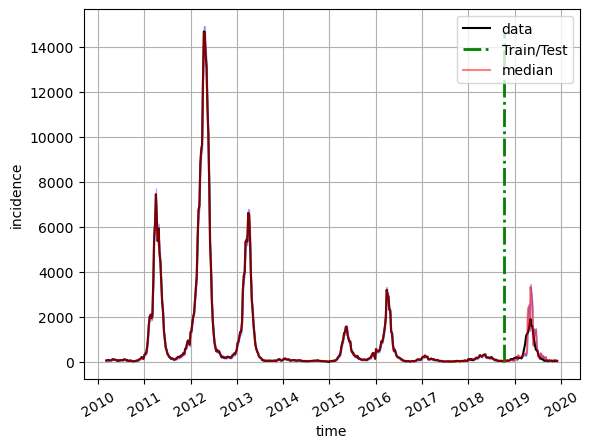

In [7]:
preds, preds25, preds975, X_train, targets = pgbm_pred(CITY, STATE, PREDICT_N, LOOK_BACK, doenca = 'dengue', ini_date = None, end_train_date = END_TRAIN_DATE, end_date = END_DATE,  filename = FILENAME_DATA)
   